<a href="https://colab.research.google.com/github/XuRui314/Kaggle-Practice/blob/main/%E8%82%A1%E7%A5%A8%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

尝试回归、SVM、随机森林和LSTM去做股票预测。

股票预测其实就是根据股票交易的一些信息来对`收盘价`进行预测，收盘价是指某种证券在证券交易所一天交易活动结束前最后一笔交易的成交价格。如当日没有成交，则采用最近一次的成交价格作为收盘价，因为收盘价是当日行情的标准，又是下一个交易日开盘价的依据，可据以预测未来证券市场行情;所以投资者对行情分析时，一般采用收盘价作为计算依据。

> 注意：这种方法本质上就是图一乐，神经网络和其他机器学习方法实际是没啥用的，
>
>原因：https://www.blueskycapitalmanagement.com/machine-learning-in-finance-why-you-should-not-use-lstms-to-predict-the-stock-market/
>
>为什么我用lstm，svm，ann来预测股价，效果都非常好？ - 雨田耳门的回答 - 知乎
https://www.zhihu.com/question/524724513/answer/2539139917

教你一个方法，没有数据穿越，甚至不用模型，图画的一样好看。直接用前一天的价格当做预测值，试着画个图吧 :)



## 数据集

这里我选了两个数据集，一个是沪深的股票，一个是国外的股票，差异还是挺大的。

In [1]:
# preparation
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/dataset/Stock_Predict")
!ls

cm_randomforest.jpg  tatatest.csv    沪深300.csv
NSE-TATAGLOBAL.csv   train_data.csv  特征重要性1.jpg


In [31]:
pip install tushare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 7.4 MB/s 
     |████████████████████████████████| 200 kB 39.6 MB/s 
     |████████████████████████████████| 130 kB 65.8 MB/s 


In [ ]:
# 网站账号：qq邮箱，密码：常用的
# 只跑一遍

# import tushare as ts
# ts.set_token('04175db220cbbfae1f2b2cc2b7171580239f666998a70421a7524e62') # https://tushare.pro/user/token
# pro = ts.pro_api()
# df = ts.pro_bar(ts_code='600519.SH', adj='qfq', start_date='20000101', end_date='20211231')
# df.to_csv("train_data.csv")
# df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600519.SH,20211231,2070.0000,2072.9800,2028.0000,2050.0000,2075.0000,-25.0000,-1.2048,29664.91,6.061415e+06
1,600519.SH,20211230,2041.0000,2088.9800,2028.0000,2075.0000,2041.0000,34.0000,1.6659,35261.36,7.272867e+06
2,600519.SH,20211229,2150.0000,2154.2500,2041.0000,2041.0000,2138.1800,-97.1800,-4.5450,54049.02,1.119563e+07
3,600519.SH,20211228,2133.0000,2155.5000,2116.6000,2138.1800,2131.8200,6.3600,0.2983,27650.70,5.901941e+06
4,600519.SH,20211227,2168.0000,2168.0000,2112.0000,2131.8200,2194.0900,-62.2700,-2.8381,37555.90,8.020678e+06
...,...,...,...,...,...,...,...,...,...,...,...
4860,600519.SH,20010831,4.9706,5.0334,4.9237,4.9518,4.9639,-0.0121,-0.2438,23231.48,8.623124e+04
4861,600519.SH,20010830,4.8542,5.0187,4.8167,4.9639,4.8675,0.0964,1.9805,48013.06,1.775586e+05
4862,600519.SH,20010829,4.9478,4.9505,4.8301,4.8675,4.9318,-0.0643,-1.3038,53252.75,1.946896e+05
4863,600519.SH,20010828,4.6816,4.9505,4.6307,4.9318,4.7565,0.1753,3.6855,129647.79,4.634631e+05


## Linear Regresssion

### 案例一

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math
import seaborn as sns
import matplotlib.pyplot as plt

数据集每列名称详情的信息：https://tushare.pro/document/2?doc_id=25

这里就把用到的介绍一下

| 名称 | 类型 | 描述 |
|--|--|--|
ts_code	|str	|股票代码
trade_date|	str	|交易日期
open	|float	|开盘价
high|	float|	最高价
low	|float	|最低价
close	|float|	收盘价
pre_close	|float|	昨收价(前复权)
change	|float|	涨跌额
pct_chg|	float	|涨跌幅 （未复权，如果是复权请用 通用行情接口 ）
vol	|float|	成交量 （手）
amount|	float	|成交额 （千元）


In [4]:
# 把时间作为index
data = pd.read_csv('train_data.csv',index_col='trade_date',
                  parse_dates=True) 
# 排序
data.sort_index(axis=0,inplace=True)
data  # 按时间倒置数据集

,Unnamed: 0,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2001-08-27,4864,600519.SH,4.6173,5.0549,4.3952,4.7565,4.1999,0.5566,13.2527,406318.00,1.410347e+06
2001-08-28,4863,600519.SH,4.6816,4.9505,4.6307,4.9318,4.7565,0.1753,3.6855,129647.79,4.634631e+05
2001-08-29,4862,600519.SH,4.9478,4.9505,4.8301,4.8675,4.9318,-0.0643,-1.3038,53252.75,1.946896e+05
2001-08-30,4861,600519.SH,4.8542,5.0187,4.8167,4.9639,4.8675,0.0964,1.9805,48013.06,1.775586e+05
2001-08-31,4860,600519.SH,4.9706,5.0334,4.9237,4.9518,4.9639,-0.0121,-0.2438,23231.48,8.623124e+04
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4,600519.SH,2168.0000,2168.0000,2112.0000,2131.8200,2194.0900,-62.2700,-2.8381,37555.90,8.020678e+06
2021-12-28,3,600519.SH,2133.0000,2155.5000,2116.6000,2138.1800,2131.8200,6.3600,0.2983,27650.70,5.901941e+06
2021-12-29,2,600519.SH,2150.0000,2154.2500,2041.0000,2041.0000,2138.1800,-97.1800,-4.5450,54049.02,1.119563e+07


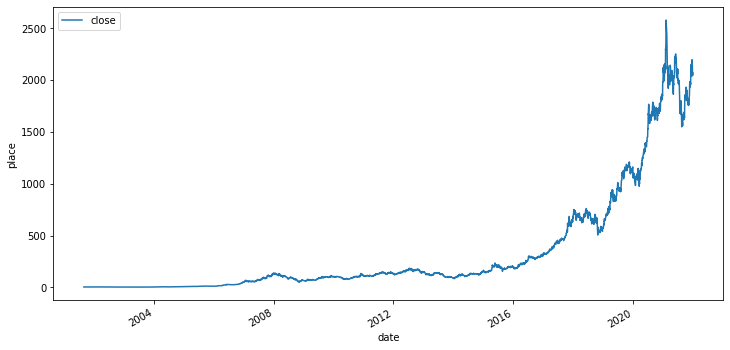

In [5]:
plt.rcParams['figure.figsize']=[12,6]
data['close'].plot()
plt.legend(loc=2)
plt.xlabel('date')
plt.ylabel('place')
plt.show()

In [6]:
forecast_col='close' 
forecast_out=300 #预测后300天收盘价
data['label']=data[forecast_col].shift(-forecast_out)
'''
采用 shift 加上负值的方法 可以把同一组数据错位的放在一起，
这个错位是把300天后的数据与当前天的数据放在同一行中，
然后两个字段数值相减就可以获得对应天数股票价格的差值
'''
data[4560:4680] #后300行（4865行之后）缺失说明操作正确，

,Unnamed: 0,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,label
trade_date,,,,,,,,,,,,
2020-09-29,304,600519.SH,1653.6954,1653.7647,1636.8249,1636.8249,1645.4434,-8.6185,-0.5238,17430.78,2.895081e+06,2131.82
2020-09-30,303,600519.SH,1644.4528,1676.0540,1644.4528,1652.8732,1636.8249,16.0483,0.9805,27087.81,4.536013e+06,2138.18
2020-10-09,302,600519.SH,1676.1531,1690.4380,1672.1905,1680.1156,1652.8732,27.2424,1.6482,34239.88,5.817281e+06,2041.00
2020-10-12,301,600519.SH,1684.0781,1734.2141,1684.0781,1734.2141,1680.1156,54.0985,3.2199,43729.04,7.597988e+06,2075.00
2020-10-13,300,600519.SH,1734.2240,1734.2240,1718.7503,1722.7129,1734.2141,-11.5012,-0.6632,22943.89,3.995561e+06,2050.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,189,600519.SH,1951.5593,1970.2525,1928.5667,1952.5400,1970.3714,-17.8314,-0.9050,31575.23,6.216733e+06,NaN
2021-03-26,188,600519.SH,1966.4089,2003.0623,1939.6618,1994.1466,1952.5400,41.6066,2.1309,50016.42,9.987629e+06,NaN
2021-03-29,187,600519.SH,2024.0638,2076.7160,2007.1735,2015.0490,1994.1466,20.9024,1.0482,56992.20,1.174013e+07,NaN


In [7]:
#构建数据集
data = data[['open', 'high', 'low', 'close','vol','label']]
data.head()

,open,high,low,close,vol,label
trade_date,,,,,,
2001-08-27,4.6173,5.0549,4.3952,4.7565,406318.00,3.9565
2001-08-28,4.6816,4.9505,4.6307,4.9318,129647.79,4.0538
2001-08-29,4.9478,4.9505,4.8301,4.8675,53252.75,4.0403
2001-08-30,4.8542,5.0187,4.8167,4.9639,48013.06,4.0044
2001-08-31,4.9706,5.0334,4.9237,4.9518,23231.48,3.9580


In [8]:
#缺失值处理
data.dropna(inplace=True)
#核实缺失值处理完毕
data.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


open     0
high     0
low      0
close    0
vol      0
label    0
dtype: int64

In [9]:
#划分特征数据和标签数据
X = np.array(data.drop(['label'], 1))
y = np.array(data['label'])

#剔除最后的300条数据
X_lately = X[-forecast_out:]  # 把最后300行单独拿出来
X = X[:-forecast_out]    #  x中存放除最后300行以外的其他信息
y = y[:-forecast_out]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [10]:
#训练数据与测试数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#创建模型
clf=LinearRegression()

#训练模型
clf.fit(X_train,y_train)

#模型预测
y_pred = clf.predict(X_test)
min(y_pred),max(y_pred)

#模型得分
confidence = clf.score(X_test, y_test)
confidence

0.9221690476625706

In [11]:
from sklearn.metrics import r2_score,mean_absolute_error
print('MAE(均方误差):',mean_absolute_error(y_test,y_pred))
print('r2(决定系数):',r2_score(y_test,y_pred))
t=mean_absolute_error(y_test,y_pred)/np.mean(y_pred)
t*=10
print('%.2f'%t) 
'''预测结果的平均值结合平均绝对误差，
可以推测该模型预测单次预测股票数据的涨跌幅范围，
即正负2.34%'''

MAE(均方误差): 64.87255557363643
r2(决定系数): 0.9221690476625706
2.48


'预测结果的平均值结合平均绝对误差，\n可以推测该模型预测单次预测股票数据的涨跌幅范围，\n即正负2.34%'

### 案例二

In [14]:
# 把时间作为index
df2 = pd.read_csv('NSE-TATAGLOBAL.csv') 

df2

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


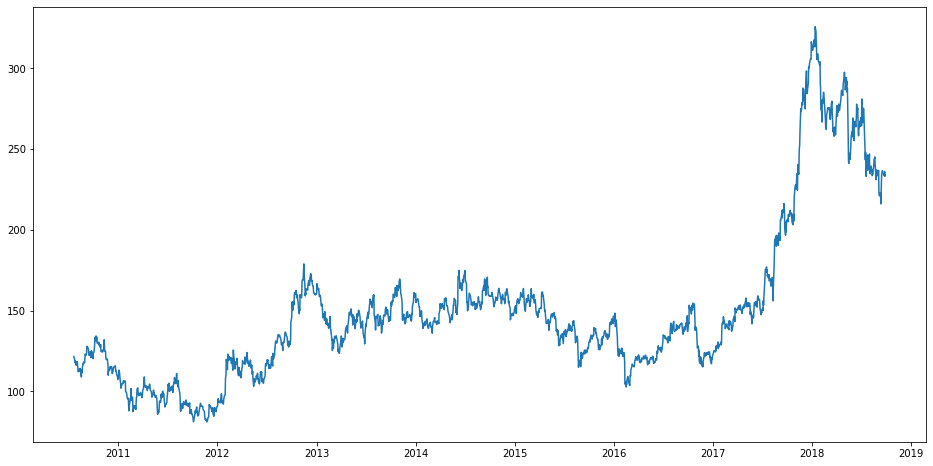

In [17]:
#setting index as date
df2['Date'] = pd.to_datetime(df2.Date,format='%Y-%m-%d')
df2.index = df2['Date']
 
#plot
plt.figure(figsize=(16,8))
plt.plot(df2['Close'], label='Close Price history')

In [18]:
df2

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-09-28,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2010-07-27,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2010-07-26,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2010-07-23,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31


In [19]:
#sorting
data2 = df2.sort_index(ascending=True, axis=0)
 
#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df2)),columns=['Date', 'Close'])
 
for i in range(0,len(data2)):
    new_data['Date'][i] = data2['Date'][i]
    new_data['Close'][i] = data2['Close'][i]


#create features
from fastai.tabular.core import add_datepart

add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp


In [20]:
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,121.55,2010,7,29,21,2,202,False,False,False,False,False,False
1,120.9,2010,7,29,22,3,203,False,False,False,False,False,False
2,120.65,2010,7,29,23,4,204,False,False,False,False,False,False
3,117.6,2010,7,30,26,0,207,False,False,False,False,False,False
4,118.65,2010,7,30,27,1,208,False,False,False,False,False,False


In [21]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data.loc[i, 'mon_fri'] = 1
    else:
        new_data.loc[i, 'mon_fri'] = 0


In [22]:
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri
0,121.55,2010,7,29,21,2,202,False,False,False,False,False,False,0
1,120.9,2010,7,29,22,3,203,False,False,False,False,False,False,0
2,120.65,2010,7,29,23,4,204,False,False,False,False,False,False,1
3,117.6,2010,7,30,26,0,207,False,False,False,False,False,False,1
4,118.65,2010,7,30,27,1,208,False,False,False,False,False,False,0


In [23]:
#split into train and validation
train = new_data[:1750]
valid = new_data[1750:]
 
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']
 
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)


LinearRegression()

In [24]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

104.19004029841115

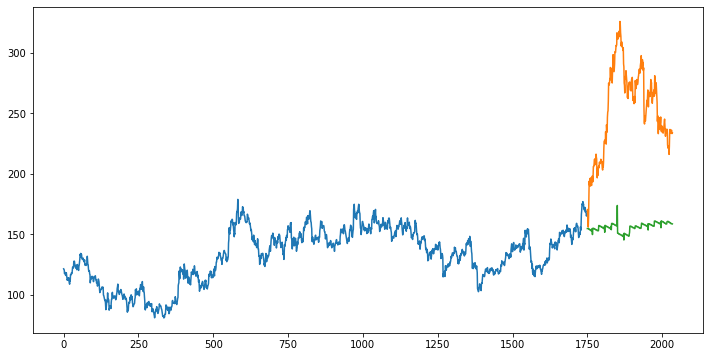

In [25]:
#plot
valid.insert(0,'Predictions',preds) #在第0列，加上column名称为Predictions，值为preds的数值。


valid.index = new_data[1750:].index
train.index = new_data[:1750].index
 
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])


## SVM

In [26]:
import pandas as pd
import numpy as np
from sklearn import svm
# sklearn下cross_validation：交叉验证
from sklearn import model_selection
#parse_dates=第0列解析为日期， index_col= 用作行索引的列编号）
data =pd.read_csv('train_data.csv',parse_dates=[0],index_col=0)
#DataFrame.sort_index(axis=0 (按0列排), ascending=True（升序）,
#inplace=False（排序后是否覆盖原数据））data 按照时间升序排列
data.sort_index(0,ascending=True,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [27]:
data.shape

(4865, 11)

In [28]:
#dayfeature：选取4856-300天的数据
#featurenum：选取的5个特征*天数
#x：记录150天的5个特征值 y：记录涨或者跌
dayfeature=4856-300
featurenum =5*dayfeature
# 即150*5， +1是将当天的开盘价引入作为一条特征数据
x=np.zeros((data.shape[0]-dayfeature,featurenum+1))
y=np.zeros((data.shape[0]-dayfeature))

经手动比对，为sigmoid时效果最好，五次实验交叉验证准确率仅为0.4-0.6

In [29]:
for i in range(0,data.shape[0]-dayfeature):
    x[i,0:featurenum]=np.array(data[i:i+dayfeature]\
                               [['close','high',   'low',u'open','vol']]).reshape((1,featurenum))
    x[i,featurenum]=data.loc[i+dayfeature]['open']
for i in range(0,data.shape[0]-dayfeature):
    if data.loc[i+dayfeature]['close']>=data.loc[i+dayfeature]['open']:
        y[i]=1
    else:
        y[i]=0
        #如果当天收盘价高于开盘价，y[i]=1代表涨，0代表跌
#创建SVM并进行交叉验证
clf =svm.SVC(kernel='sigmoid')
result =[]
for i in range(5):
    #x和y的验证集和测试集，切分80 - 20 % 的测试集
    x_train,x_test,y_train,y_test =\
        model_selection.train_test_split(x,y,test_size=0.2)
    #训练数据进行训练
    clf.fit(x_train,y_train)
    #将预测数据和测试集的验证数据比对
    result.append(np.mean(y_test ==clf.predict(x_test)))
print("svm classifier accuacy:")
print(result)

svm classifier accuacy:
[0.5806451612903226, 0.6129032258064516, 0.5806451612903226, 0.6129032258064516, 0.5645161290322581]


## Random Forest

In [40]:
import os
import time
import random
import warnings
import matplotlib
import numpy as np
import pandas as pd
import tushare as ts
from pylab import mpl
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.datasets import load_boston
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score          #预测准确度评分函数
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from matplotlib.font_manager import FontProperties
from sklearn.ensemble import RandomForestClassifier #分类决策树模型
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
path = ('沪深300.csv')
data=pd.read_csv(path,index_col=0)
data.head(10)

,name
0,002812.SZ
1,002607.SZ
2,600030.SH
3,600809.SH
4,002027.SZ
5,600299.SH
6,002044.SZ
7,300122.SZ
8,601360.SH
9,002594.SZ


In [42]:
import time
pro = ts.pro_api('04175db220cbbfae1f2b2cc2b7171580239f666998a70421a7524e62')
df1 = pd.read_csv(path,index_col=0) #读取沪深300名单
df2 = pd.DataFrame()
for i in range(int(df1.shape[0])): #df1.shape[0]是dataframe的行数
    name = df1.iloc[i,0]
    df = pro.daily(ts_code=name, start_date='20150101', end_date='20201231')
    df2 = pd.concat([df2,df])
    # print(i)
df2

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002812.SZ,20201231,139.47,142.65,136.70,141.78,139.00,2.78,2.0000,65732.55,9.212705e+05
1,002812.SZ,20201230,135.64,143.00,135.00,139.00,136.37,2.63,1.9286,70129.76,9.762302e+05
2,002812.SZ,20201229,138.65,139.80,132.00,136.37,139.25,-2.88,-2.0682,70364.81,9.512133e+05
3,002812.SZ,20201228,138.00,139.97,135.81,139.25,138.21,1.04,0.7525,54875.46,7.583881e+05
4,002812.SZ,20201225,139.69,142.29,135.00,138.21,137.80,0.41,0.2975,54871.99,7.586188e+05
...,...,...,...,...,...,...,...,...,...,...,...
1457,601318.SH,20150109,71.20,78.18,70.72,72.84,71.08,1.76,2.4800,3118734.02,2.316418e+07
1458,601318.SH,20150108,74.50,74.92,70.80,71.08,73.41,-2.33,-3.1700,1788809.15,1.288382e+07
1459,601318.SH,20150107,73.30,75.50,72.50,73.41,73.73,-0.32,-0.4300,1703868.84,1.256595e+07
1460,601318.SH,20150106,74.38,76.77,72.01,73.73,76.16,-2.43,-3.1900,2342279.69,1.743863e+07


In [43]:
df2.columns.tolist()    #读取数据列索引,做数据清洗
df = df2.sort_values(by = ['trade_date'])
df = df[['open','high','low','close','pre_close','change','pct_chg','vol','amount','ts_code','trade_date']]
df['price_change'] = df['close'] - df['pre_close']
df['change_rate'] = (df['price_change']/df['close'])*100

df
#五分类赋值函数
def fun(x):
    if x <= -5:
        return 5
    elif x < -1 and x > -5:
        return 4
    elif x < 1 and x >= -1:
        return 3
    elif x < 5 and x >= 1:
        return 2
    elif x >= 5:
        return 1
values= df['change_rate'].apply(lambda x: fun(x))
df['change_rate'] = values
df #计算出收益率,并以-5，-1，1，5为界分为五大类并赋值

,open,high,low,close,pre_close,change,pct_chg,vol,amount,ts_code,trade_date,price_change,change_rate
1461,77.80,78.80,75.25,76.16,74.71,1.45,1.9400,2435717.73,1.875204e+07,601318.SH,20150105,1.45,2
1431,3.39,3.68,3.39,3.65,3.38,0.27,7.9900,8915831.97,3.185986e+06,601899.SH,20150105,0.27,1
1294,11.16,11.39,10.89,11.26,11.12,0.14,1.2600,46383.57,5.155929e+04,600848.SH,20150105,0.14,2
1369,7.00,7.50,6.98,7.47,7.01,0.46,6.5600,2376330.79,1.742213e+06,600019.SH,20150105,0.46,1
1461,12.28,12.55,12.28,12.45,12.28,0.17,1.3800,104561.41,1.299123e+05,002311.SZ,20150105,0.17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,85.59,87.68,85.59,86.98,85.88,1.10,1.2809,795809.39,6.906072e+06,601318.SH,20201231,1.10,2
0,5.35,5.42,5.30,5.37,5.36,0.01,0.1866,594297.57,3.185052e+05,000425.SZ,20201231,0.01,3
0,156.01,156.98,153.53,155.55,155.60,-0.05,-0.0321,41837.67,6.493398e+05,603160.SH,20201231,-0.05,3
0,55.00,56.19,54.10,55.43,54.78,0.65,1.1866,59130.07,3.263388e+05,601021.SH,20201231,0.65,2


In [44]:
#归一化函数
def stand(x):
    a = (x-mins)/(maxs-mins)
    return a
#最大最小归一化
names = ['open','high','low','close','pre_close','change','pct_chg','vol','amount']
for i in names:
    maxs = df.loc[:,i].max()
    mins = df.loc[:,i].min()
    values= df[i].apply(lambda x: stand(x))
    df[i] = values
df

,open,high,low,close,pre_close,change,pct_chg,vol,amount,ts_code,trade_date,price_change,change_rate
1461,0.039568,0.038906,0.038293,0.037612,0.038127,0.380888,0.083573,0.047429,0.276003,601318.SH,20150105,1.45,2
1431,0.001211,0.001306,0.001213,0.001302,0.001206,0.377677,0.106623,0.173613,0.046893,601899.SH,20150105,0.27,1
1294,0.005217,0.005165,0.005083,0.005113,0.005212,0.377323,0.080982,0.000903,0.000759,600848.SH,20150105,0.14,2
1369,0.003072,0.003218,0.003065,0.003215,0.003085,0.378194,0.101175,0.046273,0.025643,600019.SH,20150105,0.46,1
1461,0.005794,0.005746,0.005800,0.005709,0.005813,0.377405,0.081439,0.002036,0.001912,002311.SZ,20150105,0.17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.043583,0.043350,0.043628,0.043031,0.043909,0.379935,0.081062,0.015496,0.101647,601318.SH,20201231,1.10,2
0,0.002222,0.002177,0.002198,0.002163,0.002231,0.376969,0.076893,0.011572,0.004688,000425.SZ,20201231,0.01,3
0,0.079883,0.078037,0.078686,0.077368,0.079997,0.376806,0.076060,0.000815,0.009557,603160.SH,20201231,-0.05,3
0,0.027815,0.027589,0.027379,0.027232,0.027811,0.378711,0.080703,0.001151,0.004803,601021.SH,20201231,0.65,2


In [45]:
#数据切分
df1 = df[df['trade_date']<'20180101']
df2 = df[df['trade_date']>'20180101']
#设定测试集和训练集
X_train = df1.iloc[:,:9]   
Y_train = df1.loc[:,'change_rate']
X_test = df2.iloc[:,:9]
Y_test = df2.loc[:,'change_rate']
X_train

,open,high,low,close,pre_close,change,pct_chg,vol,amount
1461,0.039568,0.038906,0.038293,0.037612,0.038127,0.380888,0.083573,0.047429,0.276003
1431,0.001211,0.001306,0.001213,0.001302,0.001206,0.377677,0.106623,0.173613,0.046893
1294,0.005217,0.005165,0.005083,0.005113,0.005212,0.377323,0.080982,0.000903,0.000759
1369,0.003072,0.003218,0.003065,0.003215,0.003085,0.378194,0.101175,0.046273,0.025643
1461,0.005794,0.005746,0.005800,0.005709,0.005813,0.377405,0.081439,0.002036,0.001912
...,...,...,...,...,...,...,...,...,...
730,0.006041,0.005906,0.006048,0.005884,0.006077,0.376969,0.076487,0.001032,0.000999
730,0.008021,0.007878,0.008029,0.007862,0.008059,0.377296,0.079154,0.000290,0.000366
730,0.015289,0.015416,0.014711,0.014557,0.014452,0.380071,0.091307,0.004362,0.010060
718,0.040712,0.039952,0.039970,0.039650,0.041450,0.374493,0.071953,0.002316,0.013940


In [46]:
change_rate = df.loc[:,'change_rate']  #取出change_rate列
change_rate.unique()  #change_rate列有哪些值
change_rate.value_counts()  #对各个值计数

3    157457
2     93095
4     92121
1     16140
5     14140
Name: change_rate, dtype: int64

In [47]:
#显著非平衡，用smote过抽样
#定义SMOTE模型，random_state相当于随机数种子的作用
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X_train,Y_train)
X_smo

,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,0.039568,0.038906,0.038293,0.037612,0.038127,0.380888,0.083573,0.047429,0.276003
1,0.001211,0.001306,0.001213,0.001302,0.001206,0.377677,0.106623,0.173613,0.046893
2,0.005217,0.005165,0.005083,0.005113,0.005212,0.377323,0.080982,0.000903,0.000759
3,0.003072,0.003218,0.003065,0.003215,0.003085,0.378194,0.101175,0.046273,0.025643
4,0.005794,0.005746,0.005800,0.005709,0.005813,0.377405,0.081439,0.002036,0.001912
...,...,...,...,...,...,...,...,...,...
364050,0.015820,0.015499,0.014278,0.014254,0.015786,0.371414,0.051641,0.002738,0.006285
364051,0.018295,0.018153,0.017268,0.016778,0.018349,0.371653,0.055878,0.000938,0.002566
364052,0.007818,0.007736,0.007308,0.007275,0.007955,0.374656,0.056692,0.006075,0.007332
364053,0.009691,0.009483,0.008820,0.008614,0.009801,0.372229,0.043164,0.004142,0.005879


In [48]:
#模型设定，拟合
model1 = RandomForestClassifier(max_depth=4, n_estimators=10, min_samples_leaf=5, random_state=1)
model1.fit(X_smo, y_smo)

RandomForestClassifier(max_depth=4, min_samples_leaf=5, n_estimators=10,
                       random_state=1)

In [49]:
#用测试集预测
y_pred = model1.predict(X_test)
a = pd.DataFrame()
a['预测值'] = list(y_pred)
a['实际值'] = list(Y_test)
a

,预测值,实际值
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3
...,...,...
204531,2,2
204532,3,3
204533,3,3
204534,2,2


In [50]:
#画图
def plot_Matrix(name, cm, classes, title=None,  cmap=plt.cm.Blues):
    plt.rc('font',family='Times New Roman',size='8')   # 设置字体样式、大小
    
    # 按行进行归一化
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    str_cm = cm.astype(np.str).tolist()
    for row in str_cm:
        print('\t'.join(row))
    # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) == 0:
                cm[i, j]=0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # 通过绘制格网，模拟每个单元格的边框
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 将x轴上的lables旋转45度
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    

    # 标注百分比信息
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) > 0:
                ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                        ha="center", va="center",
                        color="white"  if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('{}.jpg'.format(name), dpi=300)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Normalized confusion matrix
0.9997345367666578	0.0002654632333421821	0.0	0.0	0.0
0.00028676850134781197	0.9978970309901161	0.0018162005085361425	0.0	0.0
0.0001299529806488198	0.07351794532523687	0.9262339626207972	0.0001181390733171089	0.0
0.0	0.0	0.000647704350722653	0.9992412606177249	0.0001110350315524548
0.0	0.0	0.0	0.00016633399866932801	0.9998336660013307


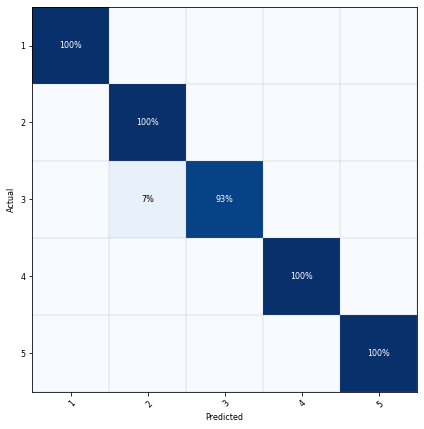

In [51]:
#得到混淆矩阵
cm = confusion_matrix(Y_test, y_pred)
#画混淆矩阵
classes = ['1','2','3','4','5']
plot_Matrix('cm_randomforest',cm, classes, title=None,  cmap=plt.cm.Blues)


#因为收益划分区间太大了，所以在3%-5%的误差允许内预测的精度如下，不得不说这是一个遗憾。--liujing

In [52]:
#分析特征变量的特征重要性
features = X_test.iloc[:,0:18].columns
importances = model1.feature_importances_
c = pd.DataFrame()
c['特征'] = features
c['特征重要性'] = importances
c = c.sort_values('特征重要性', ascending=False)
c

,特征,特征重要性
6,pct_chg,0.691684
5,change,0.263812
8,amount,0.027145
7,vol,0.009649
2,low,0.002460
3,close,0.002187
1,high,0.001883
0,open,0.000923
4,pre_close,0.000258


显然看出来pct_chg(投资收益率)这个特征值的权重大，对股价的影响大。

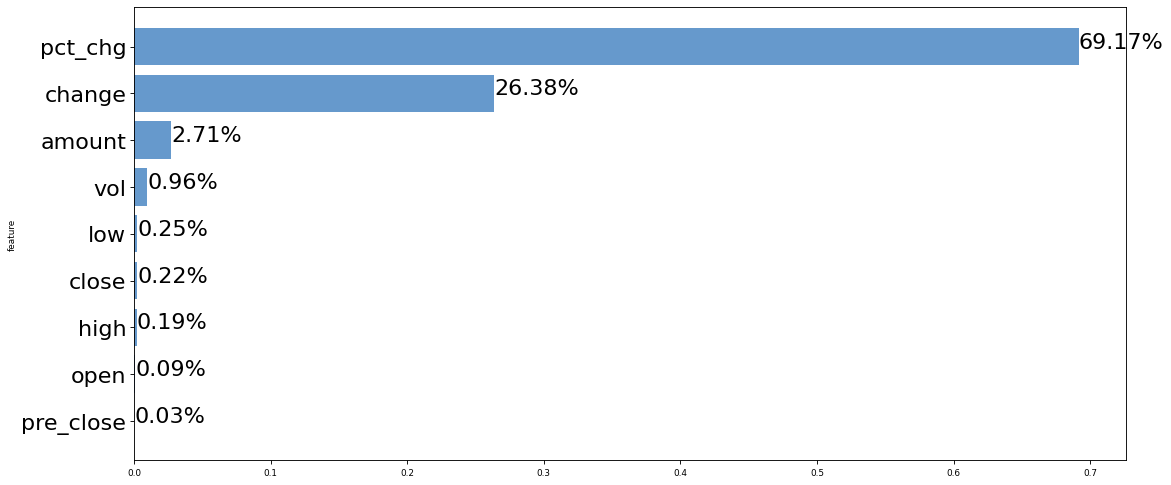

In [53]:
c.sort_values(by='特征重要性',inplace=True)
#数据
name=c.iloc[:,0]
colleges=c.iloc[:,1]
fig,ax=plt.subplots(figsize=(16, 7.5), dpi=80)
b=ax.barh(range(len(name)),colleges,color='#6699CC')
plt.ylabel('feature')
ax.set_yticks(range(len(name)))
ax.set_yticklabels(name, fontsize = 20)
plt.rc('font', size=30) 
plt.rc('axes', titlesize=20) 
lis = list(colleges)
lens = []
for i in range(len(lis)):
    lens.append(i)
for a,b in zip(lis,lens):
        plt.text(a,b+0.1,'{:.2f}%'.format(a*100),ha = 'left',va = 'center',fontsize=20)    
plt.savefig('特征重要性1.jpg')
plt.show()

## LSTM

In [34]:
df2

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-09-28,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2010-07-27,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2010-07-26,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2010-07-23,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31


In [38]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
 
#creating dataframe
data = df2.sort_index(ascending=True, axis=0)

new_data = pd.DataFrame(index=range(0,len(df2)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
 
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
 
#creating train and test sets
dataset = new_data.values

In [39]:
new_data

,Close
Date,
2010-07-21,121.55
2010-07-22,120.9
2010-07-23,120.65
2010-07-26,117.6
2010-07-27,118.65
...,...
2018-09-24,233.3
2018-09-25,236.1
2018-09-26,234.25


In [36]:
train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
 
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [32]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
 
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

927/927 - 22s - loss: 6.9702e-04 - 22s/epoch - 24ms/step


In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

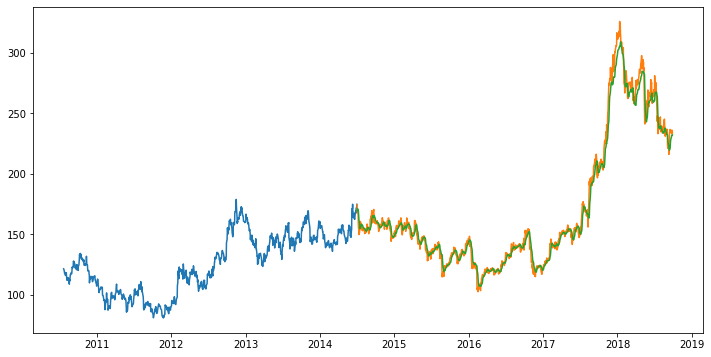

In [ ]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid.insert(0,'Predictions',closing_price) #在第0列，加上column名称为Predictions，值为closing_price的数值。

plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])